In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import ast
import warnings

sys.path.append(os.path.abspath('../src/'))
from ActivationFunctions import *
from NeuralNetwork import *
from MyUtils import *
from ModelSelection import *


%matplotlib inline

In [2]:
tr_norm_df = pd.read_csv('../data/divided_std_train_0_8.csv')
test_norm_df = pd.read_csv('../data/divided_std_test_0_2.csv')

tr_df = pd.read_csv('../data/divided_train_0_8.csv')
test_df = pd.read_csv('../data/divided_test_0_2.csv')

TR_INPUT = 10
TR_OUTPUT = 3

tr_normalized = tr_norm_df.values
test_normalized = test_norm_df.values
training_set = tr_df.values
test_set = test_df.values

scaler_out = StandardScaler()
scaler_out.fit(training_set[:,TR_INPUT:])

training_len = len(tr_norm_df)
test_len = len(test_norm_df)

In [3]:
tr_normalized[:,TR_INPUT:]

array([[ 0.53174777,  0.93677744, -1.05640618],
       [ 0.75168221, -0.24730591,  0.38017113],
       [-2.13910246,  0.81628324, -0.59278468],
       ...,
       [ 0.44348996,  0.82282244,  0.27445264],
       [-0.8963816 ,  0.87544672, -1.13567506],
       [ 0.69225741,  1.00001584, -1.57977562]])

In [4]:
def load_obj(path):    
    with open(path, 'r') as file:
        ret = json.load(file)
    for el in ret:
        with open(el['nn_file_name'], 'r') as file:
                el['model'] = NeuralNetwork.fromJSON(file.read())
    return ret
            
def save_obj(obj, path):
    for i in obj:
        with open(i['nn_file_name'], 'w+') as file:
            file.write(i['model'].toJSON())
        i['model'] = None
    json.dump(obj, path, default=str)

In [5]:
def remove_useless_val(x):
    a =['learning_rate', 'lr_decay_tau', 'alpha_momentum']
    b =['adamax_learning_rate', 'exp_decay_rate_1', 'exp_decay_rate_2']
    if x['adamax']:
        for i in a:
            if i in x.keys():
                x[i] = None
    else:
        for i in b:
            if i in x.keys():
                x[i] = None   
    return x

In [6]:
columns_order = ['topology', 'stats',
 'batch_size',
 'min_epochs',
 'max_epochs',
 'patience',
 'error_increase_tolerance',
 'lambda_tikhonov',
 
 'learning_rate',
 'alpha_momentum',
 'lr_decay_tau',
 
 'adamax',
 'adamax_learning_rate',
 'exp_decay_rate_1',
 'exp_decay_rate_2',
 
 'mean_mean_euclidean_error',
 'mean_mean_squared_error',
 'var_mean_euclidean_error',
 'var_mean_squared_error',
 'mean_best_validation_training_error']

In [7]:
results_files = ['1l_sigmoid_4_smooth.csv']
topologies = ['32_sigmoid']
folder = '../data/gs_data/'
topologies_dict = {}
gs_results = []
for i, f in enumerate(results_files):
    if os.path.isfile(folder+ f):
        dummy = pd.read_csv(folder + f)
        topologies_dict[topologies[i]] = ast.literal_eval(dummy['topology'][0])
        dummy['topology'] = topologies[i]
        
        gs_results.append(dummy)
    


orig_df = pd.concat(gs_results)
orig_df.head(1)

,adamax,alpha_momentum,batch_size,error_increase_tolerance,lambda_tikhonov,learning_rate,lr_decay_tau,max_epochs,min_epochs,patience,topology,stats,mean_mean_euclidean_error,mean_mean_squared_error,var_mean_euclidean_error,var_mean_squared_error,mean_best_validation_training_error
0,False,0.75,10,0.00001,0.000001,0.001,250,400,100,5,32_sigmoid,"{'min_epochs': 100, 'lambda_tikhonov': 1e-06, ...",0.297037,0.118063,0.000083,0.000043,0.113909


In [8]:
columns_order = [x for x in columns_order if x in orig_df.columns]
orig_df = orig_df[columns_order]

order_by = 'mean_mean_euclidean_error'
orig_df.sort_values(by=[order_by], inplace=True)
orig_df = orig_df.reset_index(drop=True)
gs_results = orig_df.drop(['stats'], axis=1)

In [9]:
#warnings.simplefilter(action='ignore', category=FutureWarning)
gs_results = gs_results.apply(remove_useless_val, axis=1)
#warnings.simplefilter(action='default', category=FutureWarning)
for i in gs_results.columns[1:]:
    gs_results[i] = gs_results[i].astype(float)

In [10]:
numerical_col = list(gs_results.columns)
numerical_col.remove('topology')
st_opt_col = ['learning_rate','lr_decay_tau','alpha_momentum']
adamax_opt_col = ['adamax','adamax_learning_rate','exp_decay_rate_1','exp_decay_rate_2']
metrics_col = [x for x in gs_results.columns if x.startswith(('var', 'mean'))]
general_col = [item for item in list(gs_results.columns) if item not in st_opt_col and item not in metrics_col and item not in adamax_opt_col]
tr_input_col = [item for item in list(gs_results.columns) if item not in metrics_col]

In [11]:
error_treshold = 10
gs_results_clean = gs_results.loc[(gs_results['mean_mean_euclidean_error'].notna()) & (gs_results['mean_mean_euclidean_error'] < error_treshold)].copy()


gs_results_clean = gs_results_clean.reset_index(drop=True)
gs_results_clean.style.background_gradient(cmap='Blues')

,topology,batch_size,min_epochs,max_epochs,patience,error_increase_tolerance,lambda_tikhonov,learning_rate,alpha_momentum,lr_decay_tau,adamax,mean_mean_euclidean_error,mean_mean_squared_error,var_mean_euclidean_error,var_mean_squared_error,mean_best_validation_training_error
0,32_sigmoid,10.000000,100.000000,400.000000,5.000000,0.000010,0.000001,0.005000,0.750000,300.000000,0.000000,0.240853,0.076503,0.000039,0.000016,0.071470
1,32_sigmoid,10.000000,100.000000,400.000000,5.000000,0.000010,0.000001,0.005000,0.750000,250.000000,0.000000,0.263758,0.091766,0.000027,0.000018,0.086637
2,32_sigmoid,10.000000,100.000000,400.000000,5.000000,0.000010,0.000001,0.002000,0.750000,300.000000,0.000000,0.283531,0.108130,0.000036,0.000049,0.104046
3,32_sigmoid,10.000000,100.000000,400.000000,5.000000,0.000010,0.000001,0.002000,0.750000,250.000000,0.000000,0.286752,0.111395,0.000019,0.000034,0.107221
4,32_sigmoid,10.000000,100.000000,400.000000,5.000000,0.000010,0.000001,0.001000,0.750000,300.000000,0.000000,0.293778,0.116790,0.000138,0.000079,0.110918
5,32_sigmoid,10.000000,100.000000,400.000000,5.000000,0.000010,0.000001,0.001000,0.750000,250.000000,0.000000,0.297037,0.118063,0.000083,0.000043,0.113909
6,32_sigmoid,10.000000,100.000000,400.000000,5.000000,0.000010,0.000001,0.000500,0.750000,300.000000,0.000000,0.308185,0.126131,0.000009,0.000020,0.121316
7,32_sigmoid,10.000000,100.000000,400.000000,5.000000,0.000010,0.000001,0.000500,0.750000,250.000000,0.000000,0.315675,0.131155,0.000033,0.000022,0.127067


In [12]:
minmaxsc = MinMaxScaler()
std_gs_results_clean = pd.DataFrame(data=minmaxsc.fit_transform(gs_results_clean[numerical_col]), columns=numerical_col)

In [13]:
def plot_gs(df, title):
    
    maps = {'adamax optimizer': adamax_opt_col,
            'standard optimizer': st_opt_col,
            'general': general_col,
            'metrics': metrics_col,
    }
    # groups and trace visibilities
    group = []
    vis = []
    visList = []
    for m in maps.keys():
        for col in numerical_col:
            if col in maps[m]:
                vis.append(True)
            else:
                vis.append(False)
        group.append(m)
        visList.append(vis)
        vis = []

    
    fig = px.line(df, title=title)
    #fig.update_layout(xaxis_range=[0, last_index])
    fig.update_yaxes(showticklabels=False)
    fig.update_traces(mode="markers+lines", hovertemplate=None)
    fig.update_layout(hovermode="x unified")

    # buttons for each group
    buttons = []
    for i, g in enumerate(group):
        button =  dict(label=g,
                    method = 'restyle',
                        args = ['visible',visList[i]])
        buttons.append(button)

    buttons = [{'label': 'all',
                    'method': 'restyle',
                    'args': ['visible', [True, True, True, True, True, True]]}] + buttons
    fig.update_layout(
        updatemenus=[
            dict(
            type="dropdown",
            direction="down",
            buttons = buttons)
        ],
    )   

    return fig

In [14]:
plot_gs(std_gs_results_clean.iloc[:25], 'GridSearch normalized values')

In [15]:
plot_gs(gs_results_clean[numerical_col].iloc[:25], 'GridSearch values')

In [16]:
#  best performance
n_best_fem = 1
sorting_values_col = ['mean_mean_euclidean_error']
classes = ['adamax']
interesting_index = []

for top in topologies_dict.keys():
    for val in list(orig_df['adamax'].value_counts().index):
        interesting_index += list(orig_df.loc[(orig_df['topology'] == top)
                                              & (orig_df['adamax'] == val)].sort_values(['mean_mean_euclidean_error']).head(n_best_fem).index)


interesting_index = list(set(interesting_index))
interesting_index

[0]

In [17]:
orig_df.iloc[interesting_index].drop(['stats'], axis=1).style.background_gradient(cmap='Blues')

,topology,batch_size,min_epochs,max_epochs,patience,error_increase_tolerance,lambda_tikhonov,learning_rate,alpha_momentum,lr_decay_tau,adamax,mean_mean_euclidean_error,mean_mean_squared_error,var_mean_euclidean_error,var_mean_squared_error,mean_best_validation_training_error
0,32_sigmoid,10,100,400,5,0.000010,0.000001,0.005000,0.750000,300,False,0.240853,0.076503,0.000039,0.000016,0.071470


In [18]:
tr_prop = int((2/3) * training_len)

def construct_obj(folder, index_list, df):
    interesting_model = []
    for i in index_list:
        
        dummy = {}
        dummy['nn_file_name'] = folder + df.iloc[i]['topology'] + '_' + str(i) + '.json'
        dummy['index'] = i
        nn, stats = train_from_index(df, tr_normalized[:tr_prop], tr_normalized[tr_prop:], i, topologies_dict, True)
        dummy['model'] = nn
        dummy['stats'] = stats
        dummy['top_name'] = df.iloc[i]['topology']
        
        dummy['std_prediction_tr'] = nn.predict_array(tr_normalized[:tr_prop,:TR_INPUT])
        dummy['std_prediction_val'] = nn.predict_array(tr_normalized[tr_prop:,:TR_INPUT])
        dummy['std_prediction_test'] = nn.predict_array(test_normalized[:,:TR_INPUT])
        
        dummy['prediction_tr'] = scaler_out.inverse_transform(dummy['std_prediction_tr'])
        dummy['prediction_val'] = scaler_out.inverse_transform(dummy['std_prediction_val'])
        dummy['prediction_test'] = scaler_out.inverse_transform(dummy['std_prediction_test'])
            
        dummy['std_tr_error'] = ErrorFunctions.mean_euclidean_error(dummy['std_prediction_tr'], tr_normalized[:tr_prop,TR_INPUT:])
        dummy['std_val_error'] = ErrorFunctions.mean_euclidean_error(dummy['std_prediction_val'], tr_normalized[tr_prop:,TR_INPUT:])
             
        dummy['tr_error'] = ErrorFunctions.mean_euclidean_error(dummy['prediction_tr'], training_set[:tr_prop,TR_INPUT:])
        dummy['val_error'] = ErrorFunctions.mean_euclidean_error(dummy['prediction_val'], training_set[tr_prop:,TR_INPUT:])
        interesting_model.append(dummy)
        
    return interesting_model


In [19]:
interesting_model = construct_obj('../data/net/models_4_smooth/', interesting_index, orig_df)

starting values:  {'training_set_len': 533, 'minibatch_size': 10, 'max_epochs': 400, 'retrainig_es_error': -1.2, 'error_increase_tolerance': 1e-05, 'patience': 5, 'min_epochs': 100, 'learning_rate': 0.0005, 'lr_decay_tau': 300, 'eta_tau': 5e-06, 'lambda_tikhonov': 1e-06, 'alpha_momentum': 0.75, 'nesterov': False, 'adamax': False, 'adamax_learning_rate': 0.0002, 'exp_decay_rate_1': 0.9, 'exp_decay_rate_2': 0.999, 'best_validation_training_error': inf, 'epochs': 0, 'total_train_time': datetime.timedelta(days=-1, seconds=86399, microseconds=999987), 'mean_epoch_train_time': 0, 'units_weights': {41: [], 40: [], 39: [], 38: [], 37: [], 36: [], 35: [], 34: [], 33: [], 32: [], 31: [], 30: [], 29: [], 28: [], 27: [], 26: [], 25: [], 24: [], 23: [], 22: [], 21: [], 20: [], 19: [], 18: [], 17: [], 16: [], 15: [], 14: [], 13: [], 12: [], 11: [], 10: [], 44: [], 43: [], 42: []}, 'units_weights_batch': {}, 'training_mean_squared_error': [], 'validation_mean_squared_error': [], 'training_mean_euclid

[1/400] tr time: 0:00:03.783578 | mean_squared_error: tr=0.8878390426369559 val=0.9754222513705557 | | mean_euclidean_error: tr=0.8739305164311919 val=0.9204128151387495 | 
[2/400] tr time: 0:00:02.019070 | mean_squared_error: tr=0.33179556961418255 val=0.38755618782421547 | | mean_euclidean_error: tr=0.5186404064028767 val=0.5641309554054975 | 
[3/400] tr time: 0:00:01.589375 | mean_squared_error: tr=0.21418208352738244 val=0.24672000604200373 | | mean_euclidean_error: tr=0.4174920079015187 val=0.446280823339252 | 
[4/400] tr time: 0:00:03.188842 | mean_squared_error: tr=0.17628531711216805 val=0.19320428805790346 | | mean_euclidean_error: tr=0.3800868951676615 val=0.3932209093299726 | 
[5/400] tr time: 0:00:05.248418 | mean_squared_error: tr=0.16047342671958206 val=0.17161900957895315 | | mean_euclidean_error: tr=0.3624333820093366 val=0.3699357413760324 | 
[6/400] tr time: 0:00:02.805083 | mean_squared_error: tr=0.15024047837005267 val=0.1580216365797198 | | mean_euclidean_error: tr

In [20]:
with open('../data/net/models_4_smooth/models.json', 'w+') as file:
    save_obj(interesting_model, file)

In [21]:
interesting_model = load_obj('../data/net/models_4_smooth/models.json')

In [22]:
df_im = pd.DataFrame(interesting_model)
def take_data(x):
    cols = ['training_mean_squared_error','validation_mean_squared_error','training_mean_euclidean_error','validation_mean_euclidean_error']
    cols_name = ['tmse','vmse','tmee','vmee']
    for i, c in enumerate(cols):
        x[cols_name[i]] = x['stats'][c]
        
    return x
df_im = df_im.apply(take_data, axis=1)
df_im = df_im.drop(['stats'], axis=1)

In [23]:
df_im

,nn_file_name,index,model,top_name,std_prediction_tr,std_prediction_val,std_prediction_test,prediction_tr,prediction_val,prediction_test,std_tr_error,std_val_error,tr_error,val_error,tmse,vmse,tmee,vmee
0,../data/net/models_4_smooth/32_sigmoid_0.json,0,id: 41 w: [ 0.04790888 -0.0415248 0.25646418...,32_sigmoid,[[ 0.43562075 1.00754399 -1.21514194]\n [ 0.7...,[[ 0.601529 -0.25223633 1.50342988]\n [ 1.2...,[[ 1.01632535 -0.84334922 1.17595384]\n [ 0.4...,[[ 0.16755795 13.41768854 4.90741639]\n [ ...,[[ 4.48554294e+00 -2.32998637e+01 3.27102559e...,[[ 15.28117525 -40.5284376 29.36115776]\n [ ...,0.267155,0.267979,5.644044,5.742377,"[0.8878390426369559, 0.33179556961418255, 0.21...","[0.9754222513705557, 0.38755618782421547, 0.24...","[0.8739305164311919, 0.5186404064028767, 0.417...","[0.9204128151387495, 0.5641309554054975, 0.446..."


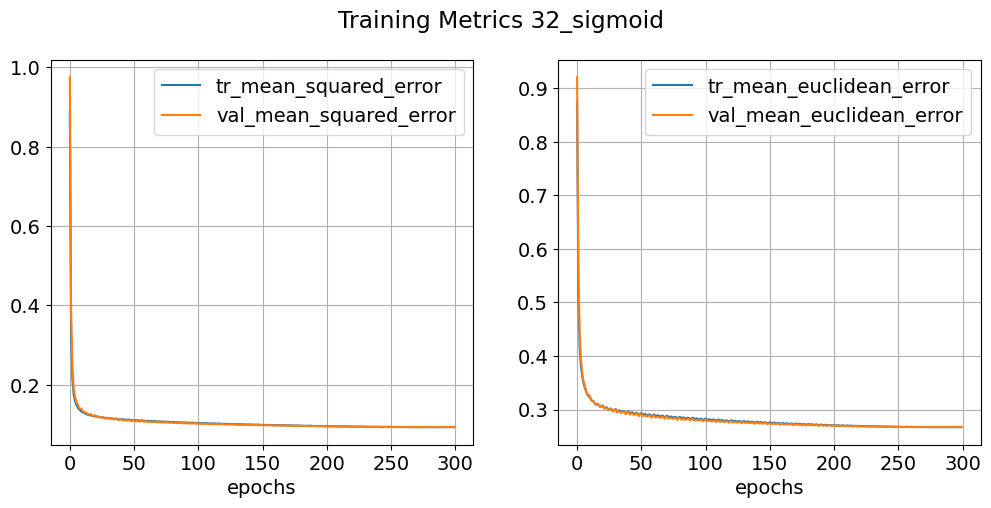

In [28]:
metrics = [ErrorFunctions.mean_squared_error, ErrorFunctions.mean_euclidean_error]
for dummy in interesting_model:
    stats = dummy['stats']
    fig, ax = plt.subplots(1, len(metrics), figsize=(12, 5))
    plt.suptitle('Training Metrics ' + dummy['top_name'])
    for i in range(len(metrics)):
        multy_plot([stats['training_' + metrics[i].__name__], stats['validation_' + metrics[i].__name__]], 
                ['tr_' + metrics[i].__name__, 'val_' + metrics[i].__name__],
                ax=ax[i])

In [25]:
dic_list = []
for dummy in interesting_model:
    dic = {}
    dic[dummy['top_name'] + 'tmse'] = dummy['stats']['training_mean_squared_error']
    dic[dummy['top_name'] + 'vmse'] = dummy['stats']['validation_mean_squared_error']
    dic[dummy['top_name'] + 'tmee'] = dummy['stats']['training_mean_euclidean_error']
    dic[dummy['top_name'] + 'vmee'] = dummy['stats']['validation_mean_euclidean_error']
    dic_list.append(pd.DataFrame(dic))
    
for i in dic_list:
    fig = px.line(i)
    fig.show()